In [1]:
import xupy as xp
import matplotlib.pyplot as plt
from numpy.ma import masked_array

from ekarus.e2e.utils.image_utils import reshape_on_mask, image_grid, get_circular_mask, remap_on_new_mask
from ekarus.e2e.devices.pyramid_wfs import PyramidWFS
from ekarus.e2e.devices.detector import Detector
from ekarus.e2e.devices.slope_computer import SlopeComputer


[XuPy] Device 0 available - GPU : `NVIDIA GeForce RTX 4060 Laptop GPU`
       Memory = 7805.56 MB | Compute Capability = 8.9
       Using CuPy 13.5.1 for acceleration.


In [2]:
def mask_with_spiders(mask, spiderWidth, spiderAngles, maskCenter=None, min_island_size:int=100):
    """
    Adds radial spiders to mask.

    Parameters
    ----------
    spiderWidth : array
        The spiders' width in pixels.
    spiderAngles : array
        Spiders' orientation angle, CCW from East.
    """
    cmask = mask.copy()
    if maskCenter is not None:
        cx,cy = maskCenter
    else:
        cx,cy = mask.shape[0]/2,mask.shape[1]/2 #mask.shape[0]//2-0.5,mask.shape[1]//2-0.5
    for angle in spiderAngles:
        cos_a = xp.cos(angle)
        sin_a = xp.sin(angle)
        dist = lambda x,y: xp.abs((xp.asarray(y-cy))*cos_a - (xp.asarray(x-cx))*sin_a)
        # Component along the spider direction (only keep pixels outward from center)
        along = lambda x,y: (xp.asarray(x-cx))*cos_a + (xp.asarray(y-cy))*sin_a
        spider_mask = xp.fromfunction(lambda j,i: (dist(i,j)<spiderWidth) & (along(i,j)>=0), mask.shape)
        cmask = xp.logical_or(cmask, spider_mask.astype(bool))

    # Identify the image petals: contiguous islands where mask == 0 (i.e. cmask == False)
    valid = ~cmask
    # use NumPy via xp.np for labeling
    valid_np = xp.asnumpy(valid).astype(bool)
    h, w = valid_np.shape
    petal_ids_np = xp.np.full((h, w), -1, dtype=int)
    cur_id = 1
    for r in range(h):
        for c in range(w):
            if valid_np[r, c] and petal_ids_np[r, c] == -1:
                stack = [(r, c)]
                petal_ids_np[r, c] = cur_id
                while stack:
                    rr, cc = stack.pop()
                    for dr, dc in ((1, 0), (-1, 0), (0, 1), (0, -1)):
                        nr, nc = rr + dr, cc + dc
                        if 0 <= nr < h and 0 <= nc < w and valid_np[nr, nc] and petal_ids_np[nr, nc] == -1:
                            petal_ids_np[nr, nc] = cur_id
                            stack.append((nr, nc))
                if xp.sum(petal_ids_np == cur_id) >= min_island_size:
                    cur_id += 1
    petal_ids = xp.asarray(petal_ids_np)
    return cmask, petal_ids

In [3]:
Npix = 128
lambdaInM = 750e-9
pupilSizeInM = 8.0
oversampling = 4

cmask = get_circular_mask((Npix,Npix),mask_radius=Npix//2,mask_center=(Npix//2-0.5,Npix//2-0.5))

# Pyramid WFS
lambdaOverD = lambdaInM/pupilSizeInM
apex_angle = 112*(2*xp.pi)*lambdaOverD
wfs = PyramidWFS(apex_angle, oversampling, sensorLambda=lambdaInM)
wfs.set_modulation_angle(modulationAngleInLambdaOverD=3)

# Detector
detector_shape = (256,256)
ccd = Detector(detector_shape=detector_shape)

# Slope computer
pars = {'modulationInLambdaOverD':0}
sc = SlopeComputer(wfs, ccd, pars)
sc.calibrate_sensor(tn='', prefix_str='pyr_', recompute=True, zero_phase=(1-cmask), lambdaOverD=lambdaOverD, Npix=64, centerObscurationInPixels=0.0)
sc._wfs.set_modulation_angle(0.0)

Modulating 3 [lambda/D] with 20 modulation steps
Defining the detector subaperture masks ...
Modulating 10 [lambda/D] with 68 modulation steps
Modulating 0 [lambda/D] with 0 modulation steps


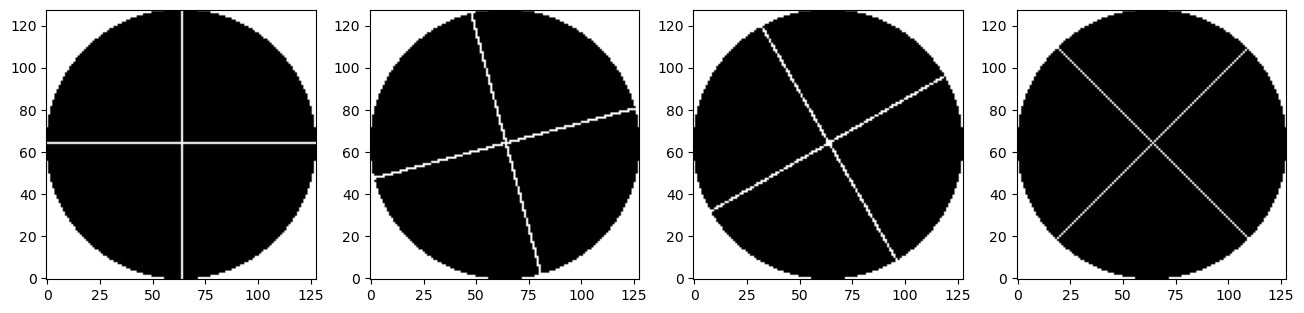

In [4]:
# 4 spiders
m2pix = Npix/pupilSizeInM
deg2rad = xp.pi/180
anglesInDeg = xp.array([0.,90.,180.,270.])
widthInM = 0.6/m2pix

aperture00, petals00 = mask_with_spiders(cmask, widthInM*m2pix, anglesInDeg*deg2rad)
aperture15, petals15 = mask_with_spiders(cmask, widthInM*m2pix, (anglesInDeg+15.)*deg2rad)
aperture30, petals30 = mask_with_spiders(cmask, widthInM*m2pix, (anglesInDeg+30.)*deg2rad)
aperture45, petals45 = mask_with_spiders(cmask, widthInM*m2pix, (anglesInDeg+45.)*deg2rad)

plt.figure(figsize=(16,3.5))
plt.subplot(1,4,1)
plt.imshow(xp.asnumpy(aperture00),origin='lower',cmap='gray')
plt.subplot(1,4,2)
plt.imshow(xp.asnumpy(aperture15),origin='lower',cmap='gray')
plt.subplot(1,4,3)
plt.imshow(xp.asnumpy(aperture30),origin='lower',cmap='gray')
plt.subplot(1,4,4)
plt.imshow(xp.asnumpy(aperture45),origin='lower',cmap='gray')

In [5]:
def make_qptt_base(petal_ids):
    Npetals = int(xp.max(petal_ids))
    tip,tilt = image_grid(petal_ids.shape,recenter=True)
    mask = petal_ids > 0
    N = 2
    QPTT = xp.zeros([N*Npetals,int(xp.sum(mask))])
    for p in range(Npetals):
        petal = (petal_ids == p+1).astype(bool)
        dpiston = xp.zeros(petal_ids.shape)
        dpiston[petal] = 1.0
        dtip = tip * petal
        dtilt = tilt * petal
        # QPTT[3*p,:] = dpiston[mask]
        # QPTT[3*p+1,:] = dtip[mask]
        # QPTT[3*p+2,:] = dtilt[mask]
        QPTT[N*p,:] =  dtip[mask]
        QPTT[N*p+1,:] = dtilt[mask]
    norm = xp.std(QPTT, axis=1)
    QPTT = (QPTT.T / norm).T
    return QPTT

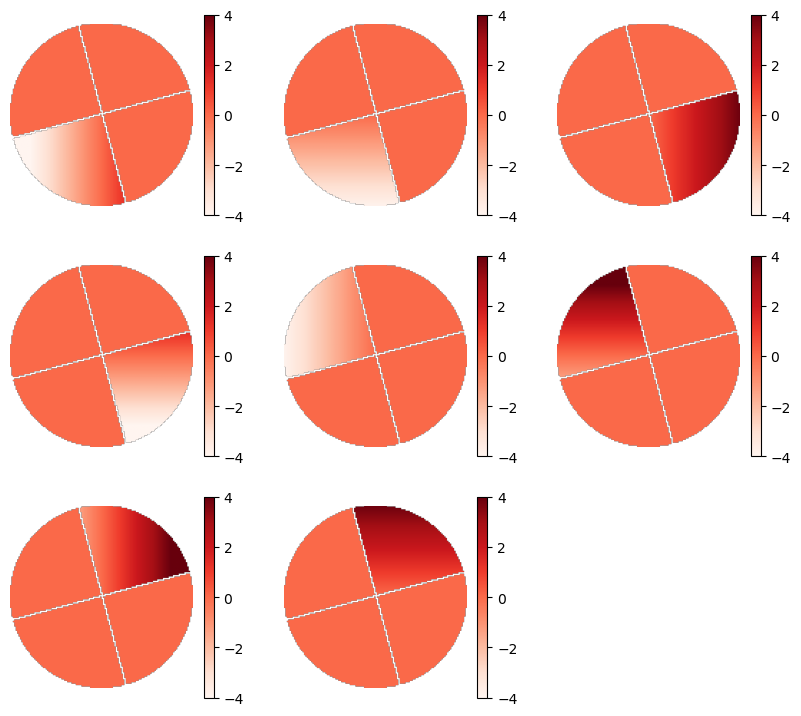

In [6]:
QPTT = make_qptt_base(petals15)
plt.figure(figsize=(10,12))
for j in range(xp.shape(QPTT)[0]):
    plt.subplot(4,3,j+1)
    shape = reshape_on_mask(QPTT[j,:], aperture15)
    plt.imshow(masked_array(xp.asnumpy(shape),mask=xp.asnumpy(aperture15)),origin='lower',cmap='Reds',vmin=-4,vmax=4)
    plt.axis('off')
    plt.colorbar()

In [7]:
from ekarus.e2e.devices.deformable_secondary_mirror import DSM

dm97 = DSM(input=11, pupil_mask=cmask, geom='alpao')
dm1200 = DSM(input=40, pupil_mask=cmask, geom='circular')

In [8]:
IF97 = remap_on_new_mask(dm97.IFF, dm97.pupil_mask, aperture15)
IF1200 = remap_on_new_mask(dm1200.IFF, dm1200.pupil_mask, aperture15)

IF = xp.vstack([IF97.T,IF1200.T]).T
cR = xp.linalg.pinv(IF)
R = xp.linalg.pinv(IF1200)

disc = QPTT[7,:]*1e-6
rec_1200_cmd = R @ disc
rec1200_shape = IF1200 @ rec_1200_cmd
diff1200 = disc - rec1200_shape

rec_cmd = cR @ disc
rec_shape = IF97 @ rec_cmd[:dm97.Nacts]
rec_shape += IF1200 @ rec_cmd[dm97.Nacts:]
diff = disc - rec_shape

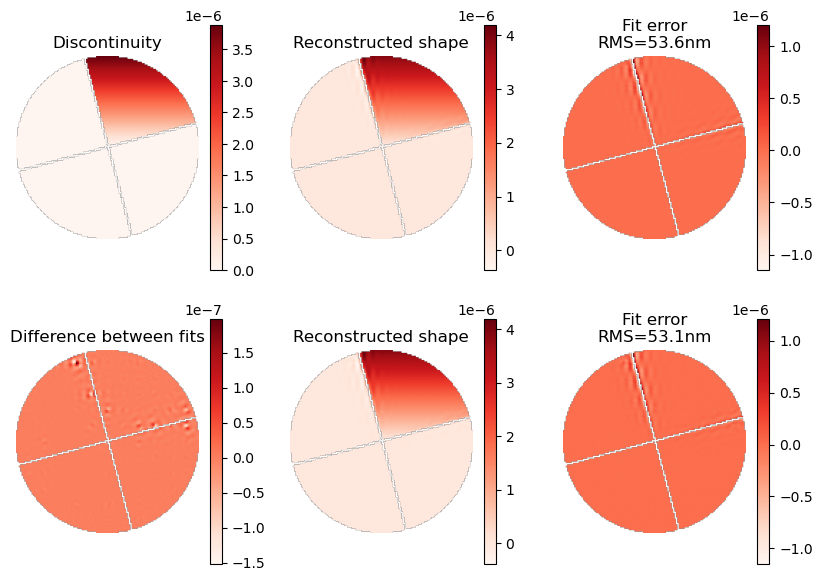

In [9]:

plt.figure(figsize=(10,7))
plt.subplot(2,3,1)
shape = reshape_on_mask(disc, aperture15)
plt.imshow(masked_array(xp.asnumpy(shape),mask=xp.asnumpy(aperture15)),origin='lower',cmap='Reds')
plt.axis('off')
plt.title('Discontinuity')
plt.colorbar()
plt.subplot(2,3,2)
shape = reshape_on_mask(rec1200_shape, aperture15)
plt.imshow(masked_array(xp.asnumpy(shape),mask=xp.asnumpy(aperture15)),origin='lower',cmap='Reds')
plt.axis('off')
plt.title('Reconstructed shape')
plt.colorbar()
plt.subplot(2,3,3)
shape = reshape_on_mask(diff1200, aperture15)
plt.imshow(masked_array(xp.asnumpy(shape),mask=xp.asnumpy(aperture15)),origin='lower',cmap='Reds')
plt.axis('off')
plt.title(f'Fit error\nRMS={xp.std(diff1200)*1e+9:1.1f}nm')
plt.colorbar()
plt.subplot(2,3,5)
shape = reshape_on_mask(rec_shape, aperture15)
plt.imshow(masked_array(xp.asnumpy(shape),mask=xp.asnumpy(aperture15)),origin='lower',cmap='Reds')
plt.axis('off')
plt.title('Reconstructed shape')
plt.colorbar()
plt.subplot(2,3,6)
shape = reshape_on_mask(diff, aperture15)
plt.imshow(masked_array(xp.asnumpy(shape),mask=xp.asnumpy(aperture15)),origin='lower',cmap='Reds')
plt.axis('off')
plt.title(f'Fit error\nRMS={xp.std(diff)*1e+9:1.1f}nm')
plt.colorbar()
plt.subplot(2,3,4)
shape = reshape_on_mask(diff-diff1200, aperture15)
plt.imshow(masked_array(xp.asnumpy(shape),mask=xp.asnumpy(aperture15)),origin='lower',cmap='Reds')
plt.axis('off')
plt.title('Difference between fits')
plt.colorbar()

In [10]:
def calibrate_petal_im(aperture, qptt, amp:float, method:str='slopes'):    
    sc._slope_method = method
    sc.slope_null = None
    sn = sc.compute_slopes(aperture, lambdaOverD, nPhotons=None)
    slope_len = len(sn)
    N = xp.shape(qptt)[0]
    IM = xp.zeros((slope_len,N))
    for p in range(N):
        dphase = reshape_on_mask(qptt[p,:]*amp,(1-aperture).astype(bool))
        print(xp.max(abs(dphase)))
        field = aperture * xp.exp(1j*dphase, dtype=xp.cfloat)
        push_slopes = sc.compute_slopes(field, lambdaOverD, nPhotons=None)
        field = aperture * xp.exp(-1j*dphase, dtype=xp.cfloat)
        pull_slopes = sc.compute_slopes(field, lambdaOverD, nPhotons=None)
        IM[:,p] = (push_slopes-pull_slopes)/(2*xp.std(xp.angle(field)))
    return IM


def get_petal_sensitivity(aperture, qptt, Rec, amp:float):
    N = xp.shape(qptt)[0]
    amp_vec = xp.linspace(-amp,amp,27,endpoint=True)
    meas_amps = xp.zeros([N,len(amp_vec)])
    for p in range(N):
        sc.slope_null = sc.compute_slopes(aperture.astype(xp.cfloat), lambdaOverD, nPhotons=None)
        for k,amp in enumerate(amp_vec):
            dphase = reshape_on_mask(qptt[p,:]*amp,(1-aperture).astype(bool))
            field = aperture * xp.exp(1j*dphase, dtype=xp.cfloat)
            slopes = sc.compute_slopes(field, lambdaOverD, nPhotons=None)
            dp_rec = Rec @ slopes
            print(dp_rec)
            meas_amps[p,k] = dp_rec[p]
    return meas_amps, amp_vec

0.09884359
0.0765034
0.07716816
0.09887234
0.07703803
0.09941864
0.10108211
0.07771559


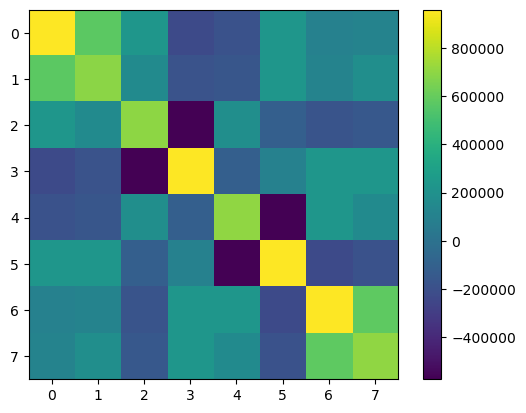

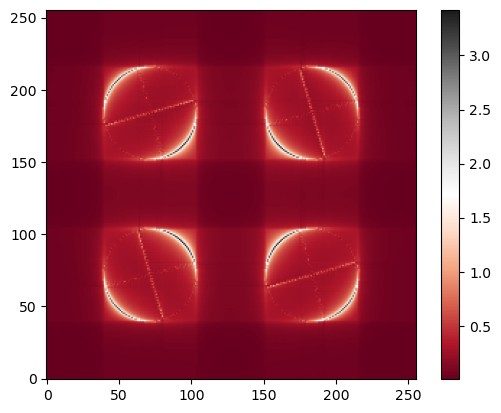

In [11]:
rad2nm = lambdaInM/(2*xp.pi)*1e+9
qptt = make_qptt_base(petals15)
aperture = 1-aperture15
IM = calibrate_petal_im(aperture, qptt, amp=0.02, method='raw_intensity')
Rec = xp.linalg.pinv(IM)
plt.figure()
plt.imshow(xp.asnumpy(IM.T @ IM))
plt.colorbar()
# plt.plot(xp.asnumpy(xp.diag(IM.T @ IM)))
# plt.xscale('log')
# plt.yscale('log')
# plt.grid()
# meas_amps, amp_vec = get_petal_sensitivity(aperture, qptt, Rec, amp=0.1)

# plt.figure()
# plt.plot(xp.asnumpy(amp_vec)*rad2nm,xp.asnumpy(amp_vec)*rad2nm,'--')
# for j in range(meas_amps.shape[0]):
#     plt.plot(xp.asnumpy(amp_vec)*rad2nm,xp.asnumpy(meas_amps[j,:]-meas_amps[j,14])*rad2nm,'--.',label=f'Petal {j:1.0f}')
# plt.grid()

plt.figure()
plt.imshow(xp.asnumpy(ccd.last_frame),cmap='RdGy',origin='lower')
plt.colorbar()

In [12]:


raise ValueError('Stop')

ValueError: Stop

In [ ]:

def plot_petal_response(petal_ids_list:list, aperture_list:list, method, max_amp:float, title_str_list:list=None, calib_amp:float=0.001):

    N = len(petal_ids_list)
    rad2nm = lambdaInM/(2*xp.pi)*1e+9
    plt.figure(figsize=(N*5.2,3.8))

    for k,petal_ids in enumerate(petal_ids_list):
        qptt = make_qptt_base(petal_ids)
        aperture = 1-aperture_list[k]
        IM = calibrate_petal_im(aperture, qptt, amp=calib_amp, method=method)
        Rec = xp.linalg.pinv(IM)
        # plt.figure()
        # plt.plot(xp.asnumpy(xp.diag(IM.T @ IM)))
        # plt.xscale('log')
        # plt.yscale('log')
        # plt.grid()
        meas_amps, amp_vec = get_petal_sensitivity(aperture, qptt, Rec, amp=max_amp)

        plt.subplot(1,N,k+1)
        plt.plot(xp.asnumpy(amp_vec)*rad2nm,xp.asnumpy(amp_vec)*rad2nm,'--')
        for j in range(meas_amps.shape[0]):
            plt.plot(xp.asnumpy(amp_vec)*rad2nm,xp.asnumpy(meas_amps[j,:])*rad2nm,'--.',label=f'Petal {j:1.0f}')
        plt.legend()
        plt.xlabel('Differential piston [nm]')
        plt.ylabel('Measured piston [nm]')
        plt.grid()
        if title_str_list is not None:
            plt.title(title_str_list[k])

[-7.94667643e+06 -8.68836649e-04 -8.68865201e-04 -7.89407817e+06
  9.05069647e-04 -7.93138288e-04 -7.89407817e+06 -7.93227659e-04
  9.04880563e-04 -7.84089586e+06  8.64391197e-04  8.64217854e-04]
[-6.78239453e+06 -7.41540217e-04 -7.41566246e-04 -6.73750254e+06
  7.72459541e-04 -6.76938367e-04 -6.73750254e+06 -6.77012336e-04
  7.72302586e-04 -6.69211206e+06  7.37740692e-04  7.37595334e-04]
[-5.70783098e+06 -6.24055338e-04 -6.24079038e-04 -5.67005141e+06
  6.50066756e-04 -5.69690976e-04 -5.67005141e+06 -5.69750729e-04
  6.49939453e-04 -5.63185234e+06  6.20847906e-04  6.20728378e-04]
[-4.72382531e+06 -5.16472503e-04 -5.16494071e-04 -4.69255877e+06
  5.37987773e-04 -4.71480905e-04 -4.69255877e+06 -4.71527639e-04
  5.37887625e-04 -4.66094506e+06  5.13805237e-04  5.13709361e-04]
[-3.83114732e+06 -4.18872324e-04 -4.18891957e-04 -3.80578932e+06
  4.36312636e-04 -3.82387726e-04 -3.80578932e+06 -3.82422650e-04
  4.36237121e-04 -3.78014977e+06  4.16699360e-04  4.16624941e-04]
[-3.03052004e+06 -3.

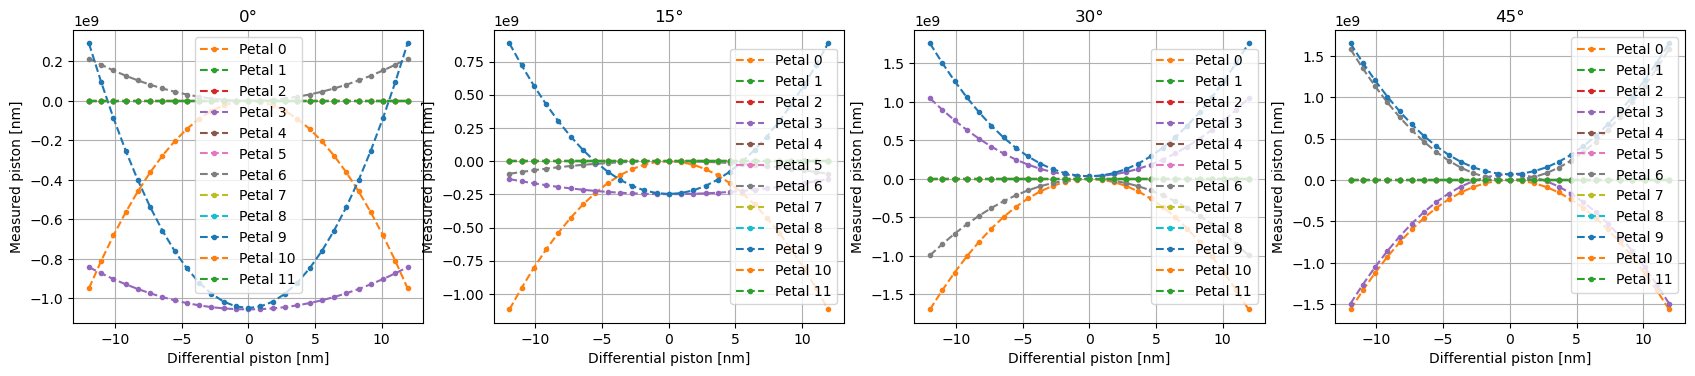

In [ ]:
plot_petal_response([petals00,petals15,petals30,petals45], [aperture00,aperture15,aperture30,aperture45], method='slopes', max_amp=0.1, title_str_list=['0°','15°','30°','45°'])

In [ ]:
# plot_petal_response([petals00,petals15,petals30,petals45],[aperture00,aperture15,aperture30,aperture45], method='raw_intensity', max_amp=0.1, title_str_list=['0°','15°','30°','45°'])

In [ ]:
# wfs.set_modulation_angle(0.0)
# plot_petal_response([petals00,petals15,petals30,petals45],[aperture00,aperture15,aperture30,aperture45], method='slopes', max_amp=0.1, calib_amp=0.1, title_str_list=['0°','15°','30°','45°'])

In [ ]:
# # 6 spiders
# anglesInDeg = xp.array([0.,60.,120.,180.,240.,300.])

# aperture00, petals00 = mask_with_spiders(cmask, widthInM*m2pix, anglesInDeg*deg2rad)
# aperture15, petals15 = mask_with_spiders(cmask, widthInM*m2pix, (anglesInDeg+15.)*deg2rad)
# aperture30, petals30 = mask_with_spiders(cmask, widthInM*m2pix, (anglesInDeg+30.)*deg2rad)
# aperture45, petals45 = mask_with_spiders(cmask, widthInM*m2pix, (anglesInDeg+45.)*deg2rad)

# plt.figure(figsize=(16,3.5))
# plt.subplot(1,4,1)
# plt.imshow(xp.asnumpy(aperture00),origin='lower',cmap='gray')
# plt.subplot(1,4,2)
# plt.imshow(xp.asnumpy(aperture15),origin='lower',cmap='gray')
# plt.subplot(1,4,3)
# plt.imshow(xp.asnumpy(aperture30),origin='lower',cmap='gray')
# plt.subplot(1,4,4)
# plt.imshow(xp.asnumpy(aperture45),origin='lower',cmap='gray')

In [ ]:
# print(petals45.shape,petals00.shape,petals30.shape,petals15.shape)

# plt.figure()
# plt.imshow(masked_array(xp.asnumpy(petals15),mask=xp.asnumpy(aperture15)),origin='lower')
# plt.colorbar()

In [ ]:
# plot_petal_response([petals00,petals15,petals30,petals45], method='slopes', max_amp=0.1, calib_amp=1e-4, title_str_list=['0°','15°','30°','45°'])
# plot_petal_response([petals00,petals15,petals30,petals45], method='raw_intensity', max_amp=0.1, calib_amp=1e-4, title_str_list=['0°','15°','30°','45°'])